In [1]:
import os

import torch
import torch.nn as nn
from tqdm import tqdm
from scipy.stats import ttest_ind
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from matplotlib import pyplot as plt
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.models.feature_extraction import create_feature_extractor

from noisypy.data.datasets import CIFAR10N
from utils import ResNet34 as resnet34

In [2]:
# Download the dataset if needed
root_dir = '../../../data'
noisy_dir = f"{root_dir}/noisylabels"
dataset = CIFAR10N(noise_type='random_label1', noise_dir=noisy_dir, cifar_dir=root_dir, download=True)

Files already downloaded and verified
Label file already downloaded and verified.


Generating the transition matrix based on random label 1 noisy labels and generating synthetic labels based on it

In [3]:
noisy_path = f"{noisy_dir}/CIFAR-10_human.pt"
noisy_labels = torch.tensor(torch.load(noisy_path, weights_only=False)["random_label1"])
noisy_labels

tensor([6, 9, 9,  ..., 9, 1, 1])

In [4]:
cifar10_train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

clean_dataset = CIFAR10(root_dir, train=True, transform=cifar10_train_transform)
clean_labels = torch.tensor(clean_dataset.targets)
clean_labels

tensor([6, 9, 9,  ..., 9, 1, 1])

In [5]:
num_classes = 10
num_repeats = 10
T = torch.zeros(num_classes, num_classes)

for i in range(num_classes):
    clean_mask = clean_labels == i
    for j in range(num_classes):
        p = (noisy_labels[clean_mask] == j).float().mean()
        T[i, j] = p
T

tensor([[0.8484, 0.0274, 0.0294, 0.0086, 0.0068, 0.0094, 0.0082, 0.0064, 0.0408,
         0.0146],
        [0.0142, 0.8466, 0.0046, 0.0088, 0.0058, 0.0046, 0.0050, 0.0048, 0.0086,
         0.0970],
        [0.0214, 0.0152, 0.8400, 0.0214, 0.0272, 0.0202, 0.0230, 0.0152, 0.0100,
         0.0064],
        [0.0158, 0.0152, 0.0440, 0.7430, 0.0188, 0.1084, 0.0240, 0.0158, 0.0072,
         0.0078],
        [0.0148, 0.0152, 0.0298, 0.0192, 0.7600, 0.0504, 0.0186, 0.0770, 0.0088,
         0.0062],
        [0.0140, 0.0108, 0.0236, 0.0818, 0.0166, 0.8234, 0.0100, 0.0126, 0.0038,
         0.0034],
        [0.0150, 0.0140, 0.0386, 0.0358, 0.0196, 0.0226, 0.8270, 0.0120, 0.0100,
         0.0054],
        [0.0148, 0.0118, 0.0074, 0.0090, 0.0206, 0.0236, 0.0072, 0.8950, 0.0062,
         0.0044],
        [0.0298, 0.0296, 0.0072, 0.0062, 0.0070, 0.0060, 0.0066, 0.0068, 0.8794,
         0.0214],
        [0.0160, 0.1258, 0.0046, 0.0050, 0.0066, 0.0080, 0.0054, 0.0054, 0.0094,
         0.8138]])

In [6]:
gen = torch.Generator("cpu").manual_seed(1337)
synthetic_labels = [torch.multinomial(T[clean_labels], 1, generator=gen).squeeze() for _ in range(num_repeats)]
synthetic_labels

[tensor([6, 9, 2,  ..., 9, 1, 1]),
 tensor([6, 9, 9,  ..., 9, 1, 1]),
 tensor([6, 9, 1,  ..., 9, 1, 1]),
 tensor([6, 9, 1,  ..., 9, 1, 1]),
 tensor([6, 1, 9,  ..., 9, 1, 1]),
 tensor([1, 1, 9,  ..., 9, 1, 1]),
 tensor([6, 9, 0,  ..., 9, 1, 1]),
 tensor([6, 9, 1,  ..., 0, 1, 1]),
 tensor([6, 1, 1,  ..., 9, 1, 1]),
 tensor([6, 9, 9,  ..., 9, 1, 1])]

Training ResNet34 on clean data

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_save_path = "model.pt"

model = resnet34(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=0.1,
    momentum=0.9,
    weight_decay=5e-4
)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, 
    milestones=[60], 
    gamma=0.1
)
loader = torch.utils.data.DataLoader(clean_dataset, batch_size=128, num_workers=4)

num_epochs = 100

In [8]:
model.to(device)

if not os.path.exists(model_save_path):
    for epoch in range(num_epochs):
        for x, y in (pbar := tqdm(loader, ncols=80, desc=f"{epoch=:3}")):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_postfix({"loss": f"{loss.item():.2e}"})
        scheduler.step()
    torch.save(model, model_save_path)

epoch= 99: 100%|███████████████| 391/391 [00:45<00:00,  8.57it/s, loss=5.42e-02]


In [9]:
model = torch.load(model_save_path, weights_only=False)

Getting image embeddings

In [10]:
model.eval()
feature_extractor = create_feature_extractor(model, {"view": "embeddings"})

# for reproducibility
loader = torch.utils.data.DataLoader(clean_dataset, batch_size=128, num_workers=0, shuffle=False)
embs = []
for i in range(num_repeats):
    with torch.no_grad():
        embs_ = []
        for x, _ in tqdm(loader, ncols=80, desc=f"Extracting features for repeat {i+1}"):
            x = x.to(device)
            emb = feature_extractor(x)["embeddings"]
            embs_.append(emb.cpu())
        embs_ = torch.cat(embs_)
    embs.append(embs_)

embs[0].shape

Extracting features for repeat 10: 100%|██████| 391/391 [00:34<00:00, 11.22it/s]


torch.Size([50000, 512])

Clustering the embeddings and plotting the results

In [11]:
cifar_class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

def generate_ps(noised_labels, embs, num_clusters=5):
    # normalizing embeddings is the same as using cosine distance
    normalized_embs = embs / (embs ** 2).sum(axis=1, keepdims=True)

    P = torch.zeros(num_classes, num_clusters, num_classes)
    for true_cls in range(num_classes):
        class_embs = normalized_embs[clean_labels == true_cls]
        emb_norm = normalize(class_embs)
        clusters = KMeans(num_clusters, n_init=10, random_state=1337).fit_predict(emb_norm)
        for c in range(num_clusters):
            for i in range(num_classes):
                P[true_cls, c, i] = (noised_labels[clean_labels == true_cls][clusters == c] == i).float().mean()
    return P

def plot_ps(P):
    per_row = 5
    num_classes = P.shape[0]
    fig, axs = plt.subplots(num_classes // per_row, per_row, figsize=(10, 5))
    for i, P_ in enumerate(P):
        ax = axs[i // per_row, i % per_row]
        ax.matshow(P_, cmap="YlGnBu")
        ax.set_title(f"class: {i} ({cifar_class_names[i]})")
    fig.tight_layout()

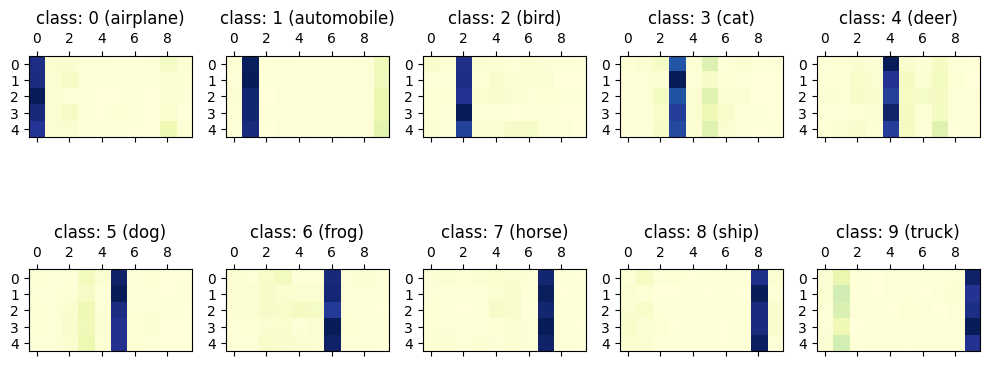

In [12]:
Ps_human = torch.stack([generate_ps(noisy_labels, emb) for emb in embs])
plot_ps(Ps_human[0])

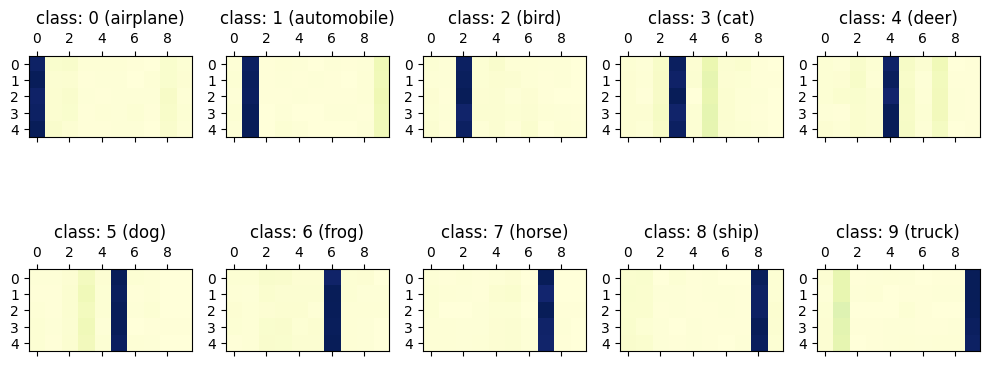

In [13]:
Ps_sythetic = torch.stack([generate_ps(lab, emb) for lab, emb in zip(synthetic_labels, embs)])
plot_ps(Ps_sythetic[0])

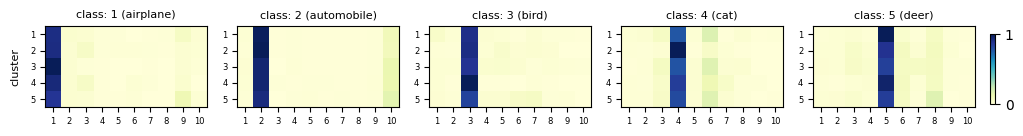

In [14]:
def plot_ps(P):
    per_row = 5
    num_classes = P.shape[0]
    fig, axs = plt.subplots(num_classes // per_row, per_row, figsize=(10, 5))
    # Draw a dummy heatmap for the colorbar
    heatmap = axs[0].matshow([[0, 1]], cmap="YlGnBu")
    for i, P_ in enumerate(P):
        ax = axs[i]
        ax.matshow(P_, cmap="YlGnBu") #  for their colormap
        ax.set_title(f"class: {i+1} ({cifar_class_names[i]})", fontsize=8)
        ax.set_xticks(list(range(P_.shape[1])))
        ax.set_xticklabels(list(range(1, P_.shape[1]+1)), fontsize=6)
        ax.xaxis.set_ticks_position('bottom')
        ax.set_yticks(list(range(P_.shape[0])))
        ax.set_yticklabels(list(range(1, P_.shape[0]+1)), fontsize=6)
            
    fig.supylabel("cluster", fontsize=8)
    fig.tight_layout()
    # Add empty axes for the colorbar
    cb_ax = fig.add_axes([1,.425,.005,.14])
    cbar = fig.colorbar(heatmap, cax=cb_ax, fraction=0.02,  ticks=[0, 1.])
    cbar.ax.set_yticklabels(["0", "1"])
    return fig
fig = plot_ps(Ps_human[0, :5])
fig.savefig("human_cluster.pdf", bbox_inches="tight")

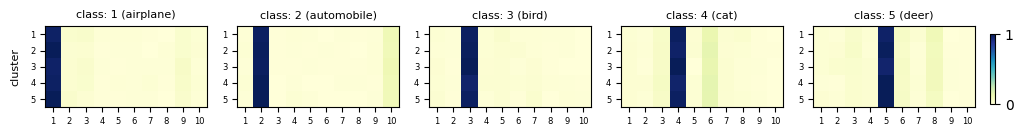

In [15]:
fig = plot_ps(Ps_sythetic[0, :5])
fig.savefig("synthetic_cluster.pdf", bbox_inches="tight")

Getting distances

In [16]:
Ps_human.shape, Ps_sythetic.shape # [repeats, true_cls, cluster, transition_cls]

(torch.Size([10, 10, 5, 10]), torch.Size([10, 10, 5, 10]))

In [17]:
d_human = ((Ps_human - Ps_sythetic) ** 2).sum(axis=(-1, -2))
d_human.shape

torch.Size([10, 10])

In [18]:
d_synthetic = ((Ps_sythetic - Ps_sythetic.roll(1, dims=0)) ** 2).sum(axis=(-1, -2))
d_synthetic.shape

torch.Size([10, 10])

Hypothesis testing with two sided t-test

In [19]:
pvals = ttest_ind(d_human, d_synthetic, equal_var=False).pvalue
pvals

array([2.16563297e-10, 2.13469551e-02, 1.97875713e-05, 1.88667950e-08,
       5.81582277e-07, 2.44298518e-05, 2.96517212e-04, 3.47932478e-02,
       2.94163895e-07, 6.84705403e-06])

(array([10., 15., 19., 17., 13., 12.,  2.,  4.,  4.,  4.]),
 array([0.00173242, 0.00625657, 0.01078072, 0.01530487, 0.01982903,
        0.02435318, 0.02887733, 0.03340149, 0.03792564, 0.04244979,
        0.04697394]),
 <BarContainer object of 10 artists>)

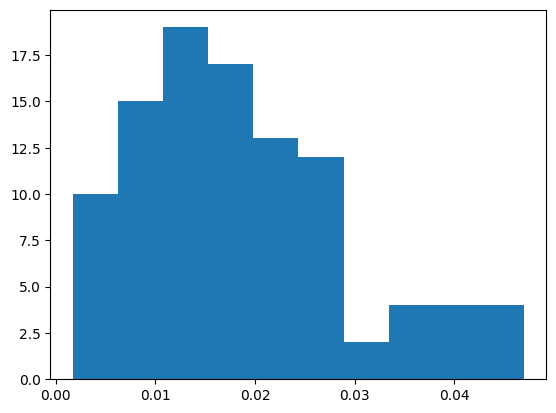

In [20]:
plt.hist(d_human.flatten())

(array([ 4., 19., 16., 27., 15.,  8.,  7.,  3.,  0.,  1.]),
 array([0.00127413, 0.00206311, 0.00285209, 0.00364107, 0.00443005,
        0.00521903, 0.00600801, 0.00679699, 0.00758597, 0.00837495,
        0.00916393]),
 <BarContainer object of 10 artists>)

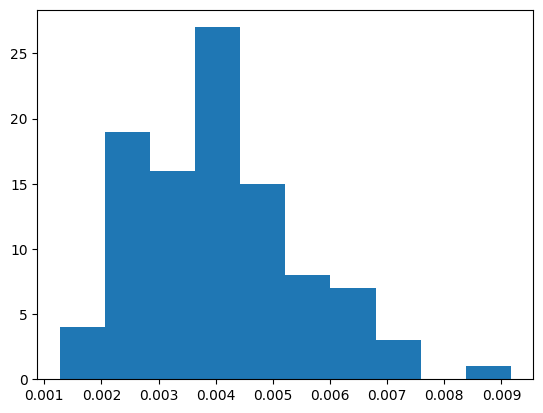

In [21]:
plt.hist(d_synthetic.flatten())

In [22]:
ttest_ind(d_human.flatten(), d_synthetic.flatten(), equal_var=False).pvalue

np.float64(1.7347132251123027e-24)